In [1]:
%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

from keras.models import Sequential, Model
from keras.layers import Input, Lambda, concatenate
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose, UpSampling2D
from keras.optimizers import SGD, Adam
from keras import metrics

from keras.datasets import mnist

from keras.utils import np_utils

from keras import backend as K

Using TensorFlow backend.


In [3]:
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()

x_train = x_train0.reshape(60000, -1)
x_test = x_test0.reshape(10000, -1)

x_train -= x_train.min()
x_train = x_train/x_train.max()

In [4]:
x = Input(shape=(784,))

enc_1 = Dense(100, activation='sigmoid')
enc_2 = Dense(2, activation='sigmoid')

h = enc_2(enc_1(x))

dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

x_hat = dec_1(dec_2(h))

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
autoencoder = Model(x, x_hat)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
_________________________________________________________________
dense_3 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_4 (Dense)              (None, 784)               79184     
Total params: 158,186
Trainable params: 158,186
Non-trainable params: 0
_________________________________________________________________


In [6]:
autoencoder.compile(loss='mse', optimizer=Adam())

In [7]:
autoencoder.fit(x_train, x_train, batch_size=32, epochs=50)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
60000/60000 [==============================] - 7s 122us/step - loss: 0.0685
Epoch 2/50
60000/60000 [==============================] - 7s 125us/step - loss: 0.0604
Epoch 3/50
60000/60000 [==============================] - 9s 153us/step - loss: 0.0559
Epoch 4/50
60000/60000 [==============================] - 8s 139us/step - loss: 0.0548
Epoch 5/50
60000/60000 [==============================] - 8s 140us/step - loss: 0.0543
Epoch 6/50
60000/60000 [==============================] - 7s 118us/step - loss: 0.0535
Epoch 7/50
60000/60000 [==============================] - 8s 133us/step - loss: 0.0526
Epoch 8/50
60000/60000 [==============================] - 8s 135us/step - loss: 0.0518
Epoch 9/50
60000/60000 [==============================] - 8s 137us/step - loss: 0.0510
Epoch 10/50
60000/60000 [==============================] - 7s 124us/step - loss: 0.0504
Epoch 11/50
60000/60000 [==============================] - 7s 120us/step - loss: 

In [8]:
Encoder = Model(x, h)
Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


In [9]:
h_input = Input(shape=(2,))
Decoder = Model(h_input, dec_1(dec_2(h_input)))

Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_4 (Dense)              (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


In [10]:
idx = np.random.randint(x_train.shape[0])
print("第 %d 圖的 latent 表示為 %s" %(idx, Encoder.predict(x_train[idx: idx+1])))

第 47625 圖的 latent 表示為 [[0.1898548 0.6859308]]


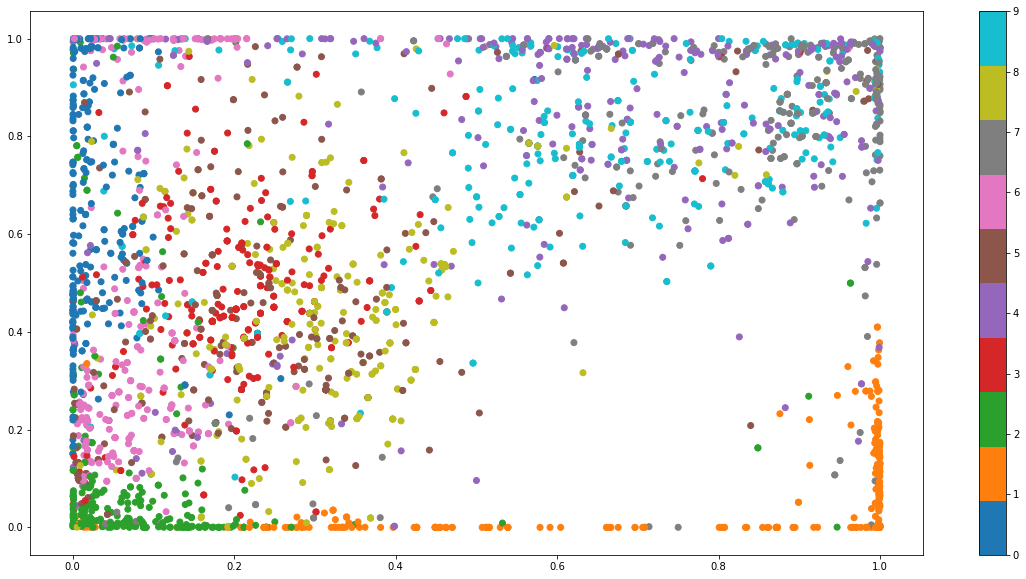

In [11]:
indices = np.random.randint(x_test.shape[0], size=3000)
latents = Encoder.predict(x_test[indices])
plt.figure(figsize=(20, 10))
plt.scatter(latents[:, 0], latents[:, 1], c=y_test0[indices], cmap="tab10")
plt.colorbar()
plt.show()

In [12]:
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(0.05, 0.95, n)
grid_y = np.linspace(0.05, 0.95, n)

In [13]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[(n-i-1) * digit_size: (n - i) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

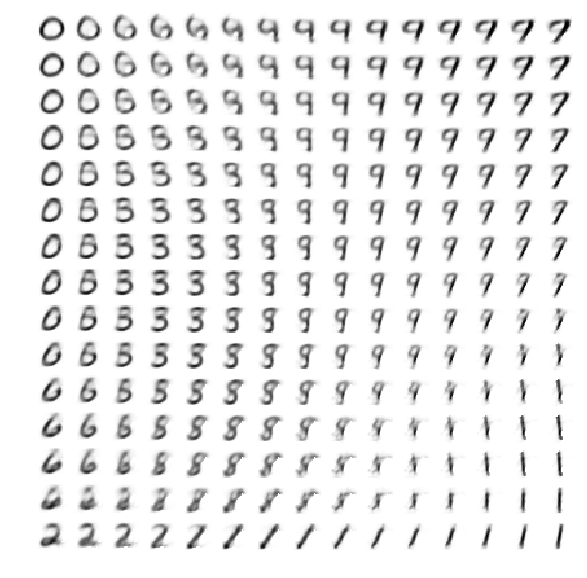

In [14]:
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys')
plt.axis('off')
plt.show()

In [15]:
enc_1 = Dense(100, activation='sigmoid')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

In [16]:
x = Input(shape=(784,))
enc_x = enc_1(x)

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

In [17]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0., stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [18]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [19]:
dec_x = dec_2(z)
x_hat = dec_1(dec_x)

In [20]:
VAE = Model(x, x_hat)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 100)          78500       input_3[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 2)            202         dense_5[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 2)            202         dense_5[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

In [21]:
def vae_loss(x, x_recon):  
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return recovery_loss + kl_loss

In [22]:
VAE.compile(loss=vae_loss, optimizer=Adam())

In [23]:
VAE.fit(x_train, x_train, batch_size=32, epochs=50)

Epoch 1/50
60000/60000 [==============================] - 10s 167us/step - loss: 195.3074
Epoch 2/50
60000/60000 [==============================] - 10s 171us/step - loss: 181.5047
Epoch 3/50
60000/60000 [==============================] - 10s 163us/step - loss: 179.9160
Epoch 4/50
60000/60000 [==============================] - 10s 162us/step - loss: 177.3793
Epoch 5/50
60000/60000 [==============================] - 10s 162us/step - loss: 174.6291
Epoch 6/50
60000/60000 [==============================] - 10s 173us/step - loss: 171.8751
Epoch 7/50
60000/60000 [==============================] - 10s 174us/step - loss: 169.3483
Epoch 8/50
60000/60000 [==============================] - 10s 165us/step - loss: 167.0941
Epoch 9/50
60000/60000 [==============================] - 9s 155us/step - loss: 165.0455
Epoch 10/50
60000/60000 [==============================] - 10s 160us/step - loss: 163.2930
Epoch 11/50
60000/60000 [==============================] - 9s 153us/step - loss: 161.8034
Epoch 12/5

In [24]:
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


In [25]:
VAE_Decoder = Model(h_input, dec_1(dec_2(h_input)))

VAE_Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_9 (Dense)              (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


In [26]:
VAE_latents = VAE_Encoder.predict(x_test[indices])

In [27]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [28]:
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

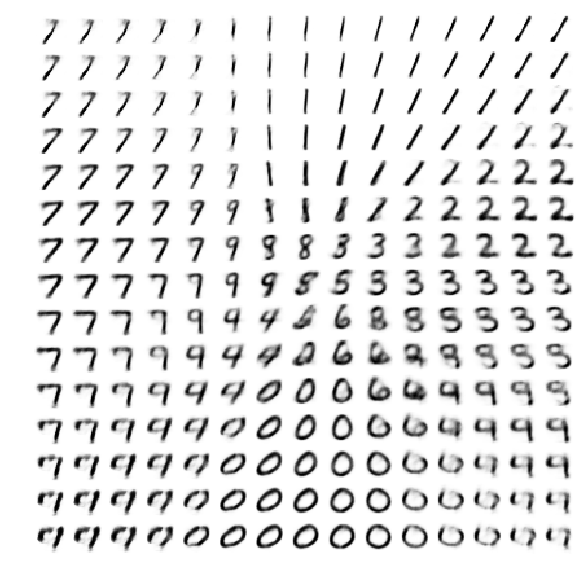

In [29]:
plt.figure(figsize=(10, 10))
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()

In [30]:
def inBetween(t):
    data_0 = x_train0[idx_1]
    data_1 = x_train0[idx_2]
    data_t = (1-t)*x_train0[idx_1] + t*x_train0[idx_2]

    mu_0 = VAE_Encoder.predict(x_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(x_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='Greys')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


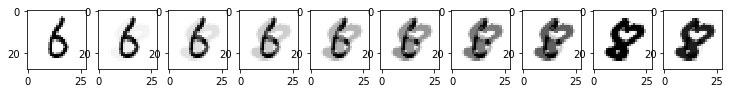

In [45]:
idx_1, idx_2 = np.random.randint(x_test.shape[0], size=2) # 自10000個Test手寫數字資料中隨機取出2個數字
data_0 = x_train0[idx_1]
data_1 = x_train0[idx_2]

plt.figure(figsize=(15, 15))
data_0 = x_train0[idx_1]
ax2 = plt.subplot(2, 3, 2)
ax2.imshow(data_0, cmap='Greys')

sx =1

for t in np.arange(0, 1, 0.1):
    data_t = (1-t)*x_train0[idx_1] + t*x_train0[idx_2]
    ax3 = plt.subplot(2, 12, sx )
    ax3.imshow(data_t, cmap='Greys')
    sx = sx+1
ax4 = plt.subplot(2, 12, 9)
ax4.imshow(data_1, cmap='Greys')

In [46]:
interact(inBetween, t=FloatSlider(value=0.5, 
                                  min=0, 
                                  max=1.0,
                                  step=0.02,))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.02), Output()), _dom_classes=('w…

<function __main__.inBetween(t)>